<a href="https://colab.research.google.com/github/hargurjeet/MachineLearning/blob/master/Predictive_Maintaince_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the dataset

In [1]:
!pip install opendatasets 

In [2]:
# To Imporing dataset from kaggle
import opendatasets as od

# For data preprocessing
import pandas as pd
import numpy as np

# To build visualizations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats
import pylab

# To build ML models
from fbprophet import Prophet
from matplotlib import pyplot as plt
import pandas.util.testing as tm

from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
# using pandas library to import the dataset
# Setting the data columns to index and for the convience to perfrom data analysis
od.download('https://www.kaggle.com/shivamb/machine-predictive-maintenance-classification')
df = pd.read_csv("/content/machine-predictive-maintenance-classification/predictive_maintenance.csv")
df.head()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hargurjeet
Your Kaggle Key: ··········


100%|██████████| 137k/137k [00:00<00:00, 19.5MB/s]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
## understanding the importance of both the features

print(df.Target.value_counts(), df['Failure Type'].value_counts())

0    9661
1     339
Name: Target, dtype: int64 No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64


definately both the features are different

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [6]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Target,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0


In [8]:
df_relevant_features = df.drop('UDI', axis=1)
df_relevant_features.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


EDA - Indiviual features

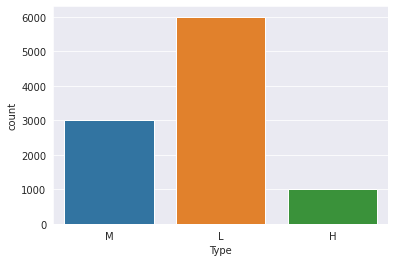

In [9]:
sns.set_style("darkgrid")
ax = sns.countplot(x="Type", data=df_relevant_features)
# plt.grid()
plt.show()

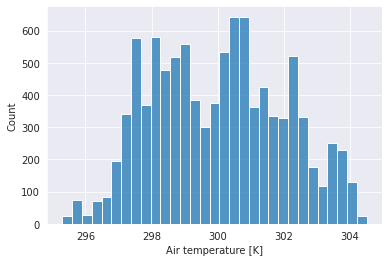

In [10]:
sns.set_style("darkgrid")
ax = sns.histplot(x="Air temperature [K]", data=df_relevant_features)
plt.show()

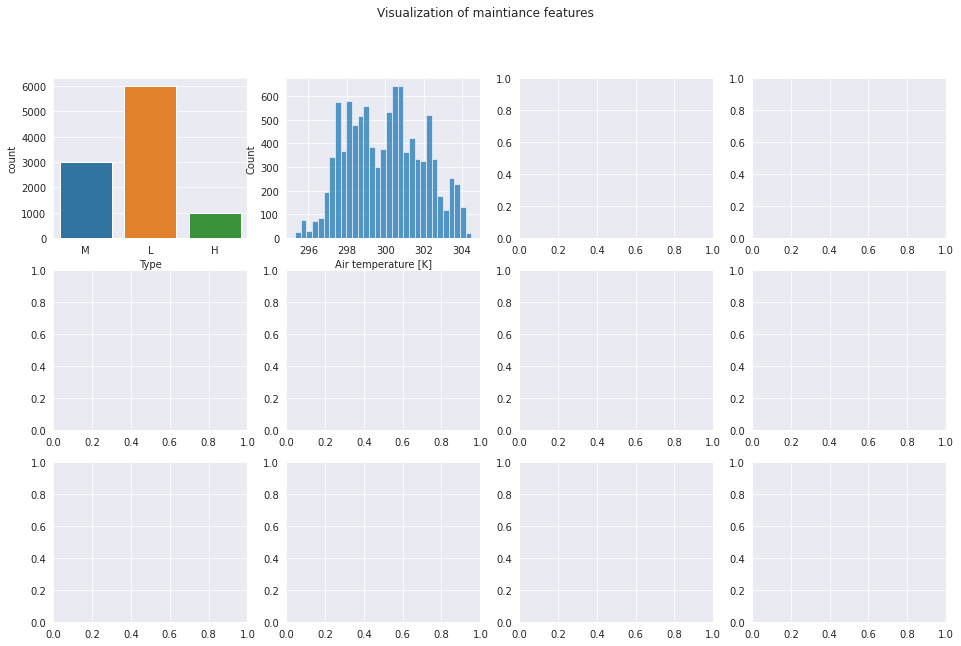

In [26]:
fig, axes = plt.subplots(3, 4, figsize=(16,10))
fig.suptitle('Visualization of maintiance features')

#Type
sns.countplot(ax=axes[0,0], x=df_relevant_features.Type, data=df_relevant_features)
# axes[0, 0].set_title('Type')

#Air Temperature
sns.histplot(ax=axes[0,1], x="Air temperature [K]", data=df_relevant_features)
# axes[0, 1].set_title("Air Temperature")